<div style="text-align:center; border: 1px solid #808080; padding: 10px;">
  <h1 style="color: gray; font-weight: bold;">Credit Card Predictive Analysis | EDA:</h1>
  <h2 style="color: gray; font-weight: bold;">Credit Risk Classification Using  Model of Best Fit</h2>
</div>

# **Problem Statement**

- Credit score cards are used in the financial industry to predict the likelihood of credit card defaults and guide the issuance of credit cards. These scores rely on applicants' personal data and historical information, quantifying risk objectively.

**Project Goal**:
- The primary objective of this project is to **build a predictive model** that accurately identifies whether a customer is **high-risk** for credit card approval, enabling data-driven decision-making in the credit screening process.

## Huggingface model samples
- aegishield/credit_card_purchase_prediction
- timhbach/Team-Gryffindor-DistilBERT-finetuned-ner-creditcardcontract
- PabitraJiban/Credit-card-collection-intent-classification

## Load libraries & helpers

In [1]:
%matplotlib inline

import os
import sys
import importlib
from autoviz import AutoViz_Class

import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("../scripts")
from data_processing_framework import *

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


ModuleNotFoundError: No module named 'data_processing_framework'

## Data load & understanding

In [2]:
path = "rikdifos/credit-card-approval-prediction"
result = fetch_kaggle_dataset_by_path(path, temp_dir=".temp_kaggle")

📦 Fetching Kaggle dataset: rikdifos/credit-card-approval-prediction
Dataset URL: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction


Dropdown(description='Select File:', options=('application_record.csv', 'credit_record.csv'), value='applicati…

Button(description='📥 Load Selected File', style=ButtonStyle())

Output()

🔄 Select a file to load individually. You can rerun to load others.


In [3]:
# load dataset 1
appl_df = raw_df

In [4]:
# load dataset 2
credits_df = raw_df

---
*Credit df:*
> 1048575 entries, Data columns (total 3 columns)

*Application df:*
> 438557 entries , Data columns (total 18 columns)


| Feature Name    | Explanation     | Remarks                                                                                       |
|-----------------|-----------------|-----------------------------------------------------------------------------------------------|
| MONTHS_BALANCE  | Record month    | The month of the extracted data is the starting point, backwards, `0 is the current month`, `-1 is the previous month`, and so on |
| STATUS          | Status          | `0: 1-29 days past due` `1: 30-59 days past due` `2: 60-89 days overdue` `3: 90-119 days overdue` `4: 120-149 days overdue` `5: Overdue or bad debts, write-offs for more than 150 days` `C: paid off that month` `X: No loan for the month` |

---

## Creating the target variable (is_high_risk)

---
To create the target column Is_high_risk (binary: 1 for risky, 0 for not risky),

- Step 1: Define Risky Statuses: Based on the STATUS column, classify customers as "risky" if they have ever had a severe delinquency (e.g., 30+ days overdue). Common thresholds include:
- > STATUS = 1, 2, 3, 4, or 5 (60+ days past due).

- Step 2: Aggregate Customer Behavior: Group the data by ID and check if the customer has any risky status in their history:
- I will merge the two dataframes based on the `ID` column, using the `inner` parameter in the `pd.merge` function.
- ---

In [5]:
# Calculate account age and target variable:is_high_risk
# Group by ID and find the earliest (most negative) months_balance
account_age = credits_df.groupby('ID')['MONTHS_BALANCE'].min().abs()

# Define the severity order of statuses and create target variable
status_severity = {
    '5': 7,  # Most severe - Overdue >150 days
    '4': 6,  # 120-149 days overdue
    '3': 5,  # 90-119 days overdue
    '2': 4,  # 60-89 days overdue
    '1': 3,  # 30-59 days past due
    '0': 2,  # 1-29 days past due
    'C': 1,  # Paid off
    'X': 0   # No loan
}

target_df =credits_df.copy()

# Sort by ID and months_balance (descending to get most recent first)
target_df = target_df.sort_values(['ID', 'MONTHS_BALANCE'], ascending=[True, False])

# Keep only the most recent record for each ID
target_df = target_df.drop_duplicates(subset=['ID'], keep='first')

# Create is_high_risk based on the most recent status
target_df['is_high_risk'] = target_df['STATUS'].isin(['1','2','3', '4', '5']).astype(int)
target_df['account_age_months'] = target_df['ID'].map(account_age)
target_df = target_df[['ID', 'account_age_months','is_high_risk']]

target_df

,ID,account_age_months,is_high_risk
0,5001711,3,0
4,5001712,18,0
23,5001713,21,0
45,5001714,14,0
60,5001715,59,0
...,...,...,...
1048494,5150482,28,0
1048512,5150483,17,0
1048530,5150484,12,0
1048543,5150485,1,0


In [6]:
# Merge target variable (credits_df)  with latest application data
merged_df = appl_df.merge(target_df, on='ID', how='inner')
# Fill any missing is_high_risk values with 0 (assuming no record means no risk)
merged_df['is_high_risk'] = merged_df['is_high_risk'].fillna(0)
display(merged_df.head())
for col in merged_df.columns:
    print(f"{col}: {merged_df[col].unique()}")

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,account_age_months,is_high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


ID: [5008804 5008805 5008806 ... 5149838 5150049 5150337]
CODE_GENDER: ['M' 'F']
FLAG_OWN_CAR: ['Y' 'N']
FLAG_OWN_REALTY: ['Y' 'N']
CNT_CHILDREN: [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL: [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  472500.   196650.   630000.   43200

**Column Description of Merged Dataset:**

| Feature Name        | Explanation                  | Remarks                                                  |
|---------------------|------------------------------|----------------------------------------------------------|
| ID                  | Client number                |                                                          |
| CODE_GENDER         | Gender                       |                                                          |
| FLAG_OWN_CAR        | Is there a car               |                                                          |
| FLAG_OWN_REALTY     | Is there a property          |                                                          |
| CNT_CHILDREN        | Number of children           |                                                          |
| AMT_INCOME_TOTAL    | Annual income                |                                                          |
| NAME_INCOME_TYPE    | Income category              |                                                          |
| NAME_EDUCATION_TYPE | Education level              |                                                          |
| NAME_FAMILY_STATUS  | Marital status               |                                                          |
| NAME_HOUSING_TYPE   | Way of living (House Type)                |                                                          |
| DAYS_BIRTH          | Birthday                     | Count backwards from current day (0), -1 means yesterday |
| DAYS_EMPLOYED       | Start date of employment     | Count backwards from current day(0). If positive, it means the person is currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone      |                                                          |
| FLAG_WORK_PHONE     | Is there a work phone        |                                                          |
| FLAG_PHONE          | Is there a phone             |                                                          |
| FLAG_EMAIL          | Is there an email            |                                                          |
| OCCUPATION_TYPE     | Occupation                   |                                                          |
| CNT_FAM_MEMBERS     | Family size                  |                                                          |


## Initial EDA / Data Quality Checks

Shape of your Data Set loaded: (36457, 20)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']
    Integer-Categorical Columns: ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'account_age_months']
    String-Categorical Columns: ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    Numeric-Boolean Columns: ['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: ['ID']
    

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
CODE_GENDER,object,0.000000,0,,,No issue
FLAG_OWN_CAR,object,0.000000,0,,,No issue
FLAG_OWN_REALTY,object,0.000000,0,,,No issue
CNT_CHILDREN,int64,0.000000,0,0.000000,19.000000,"Column has 454 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them., Column has a high correlation with ['CNT_FAM_MEMBERS']. Consider dropping one of them."
AMT_INCOME_TOTAL,float64,0.000000,NA,27000.000000,1575000.000000,Column has 1331 outliers greater than upper bound (380250.00) or lower than lower bound(-33750.00). Cap them or remove them.
NAME_INCOME_TYPE,object,0.000000,0,,,1 rare categories: ['Student']. Group them into a single category or drop the categories.
NAME_EDUCATION_TYPE,object,0.000000,0,,,1 rare categories: ['Academic degree']. Group them into a single category or drop the categories.
NAME_FAMILY_STATUS,object,0.000000,0,,,No issue
NAME_HOUSING_TYPE,object,0.000000,0,,,"2 rare categories: ['Office apartment', 'Co-op apartment']. Group them into a single category or drop the categories."
DAYS_BIRTH,int64,0.000000,22,-25152.000000,-7489.000000,No issue


Total Number of Scatter Plots = 3
All Plots are saved in reports_html\is_high_risk
Time to run AutoViz = 14 seconds 


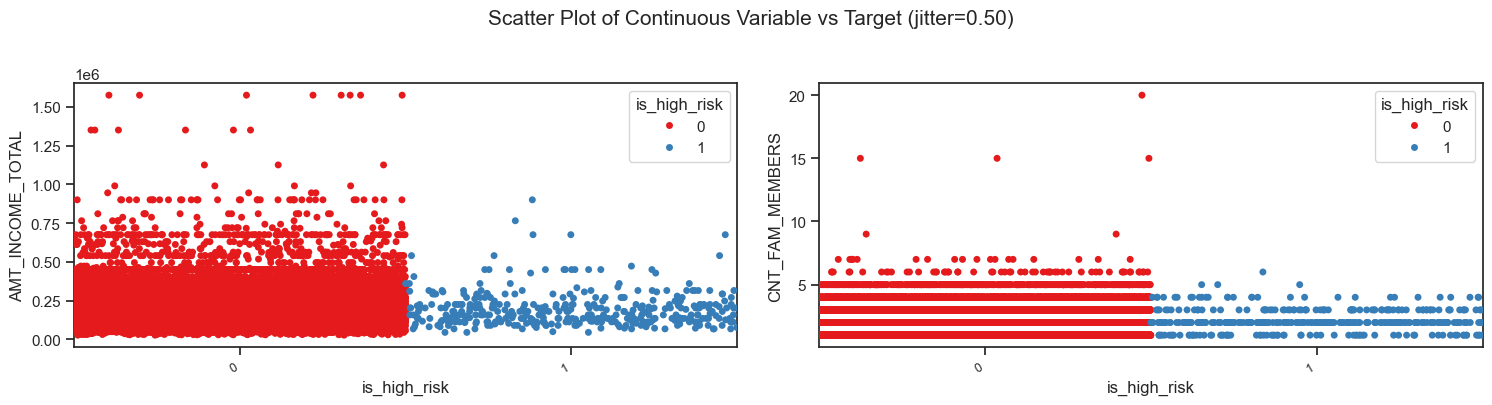

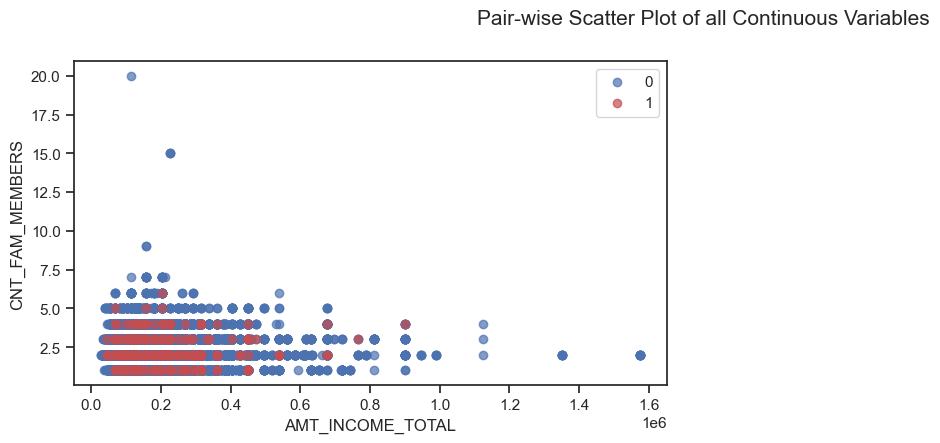

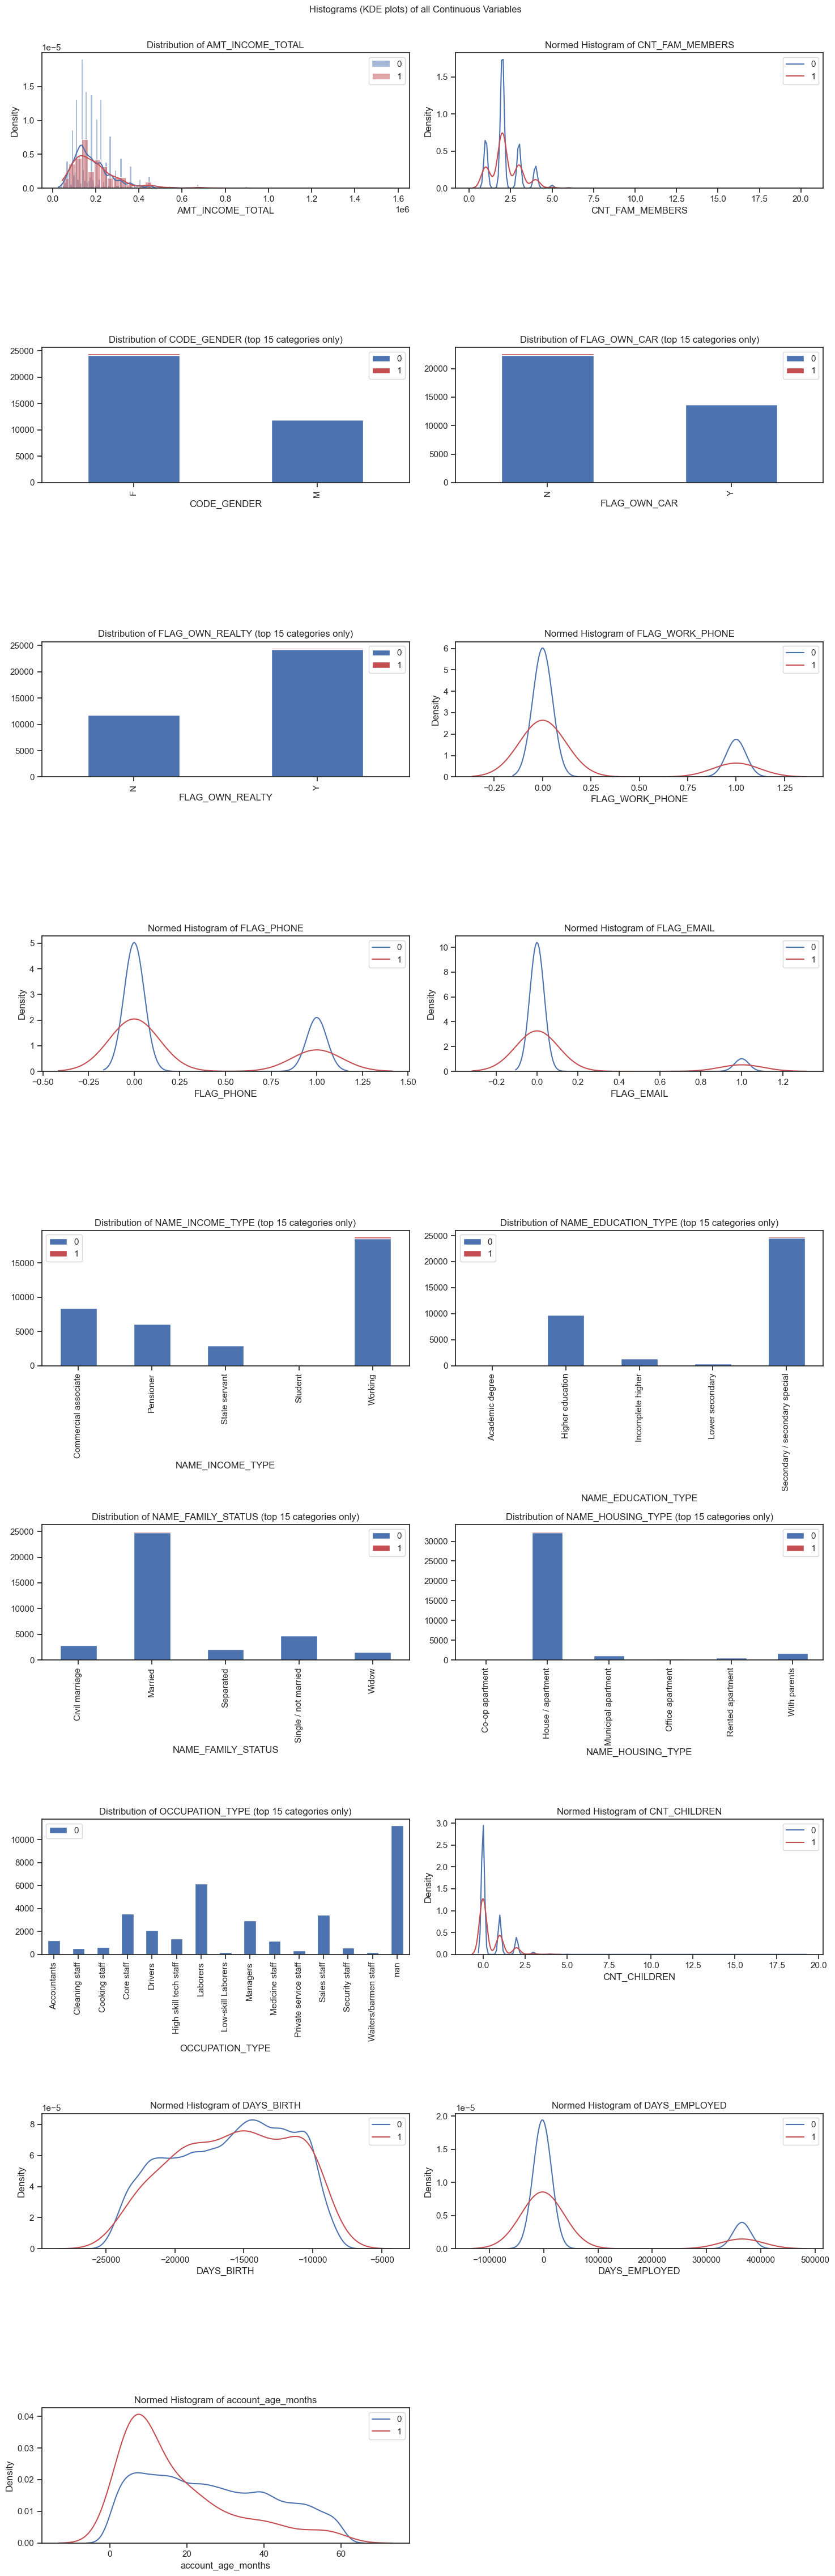

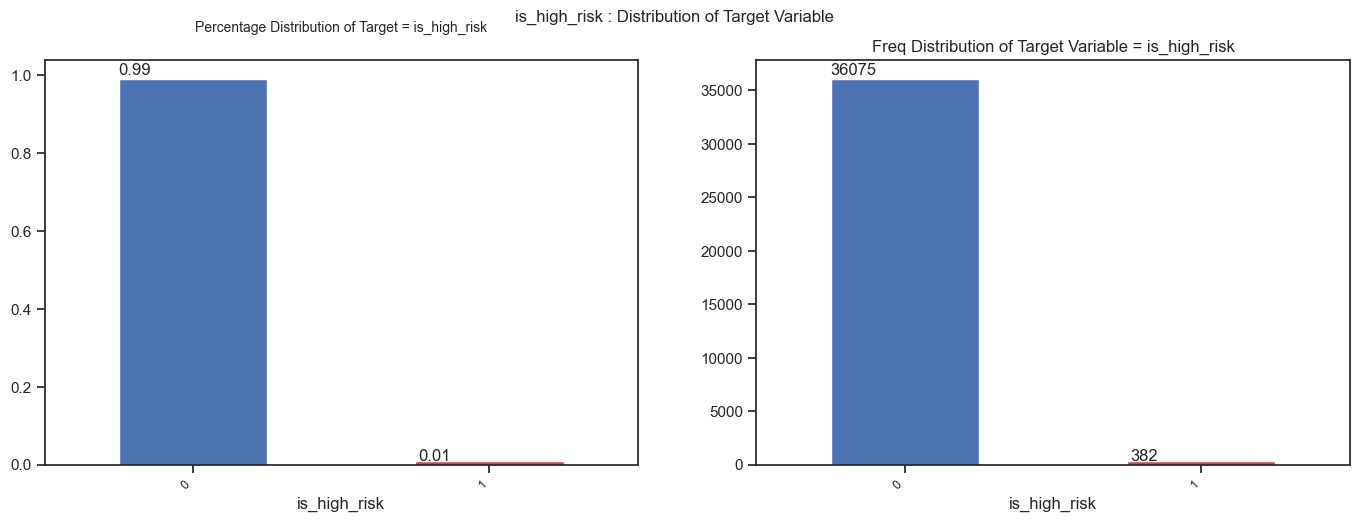

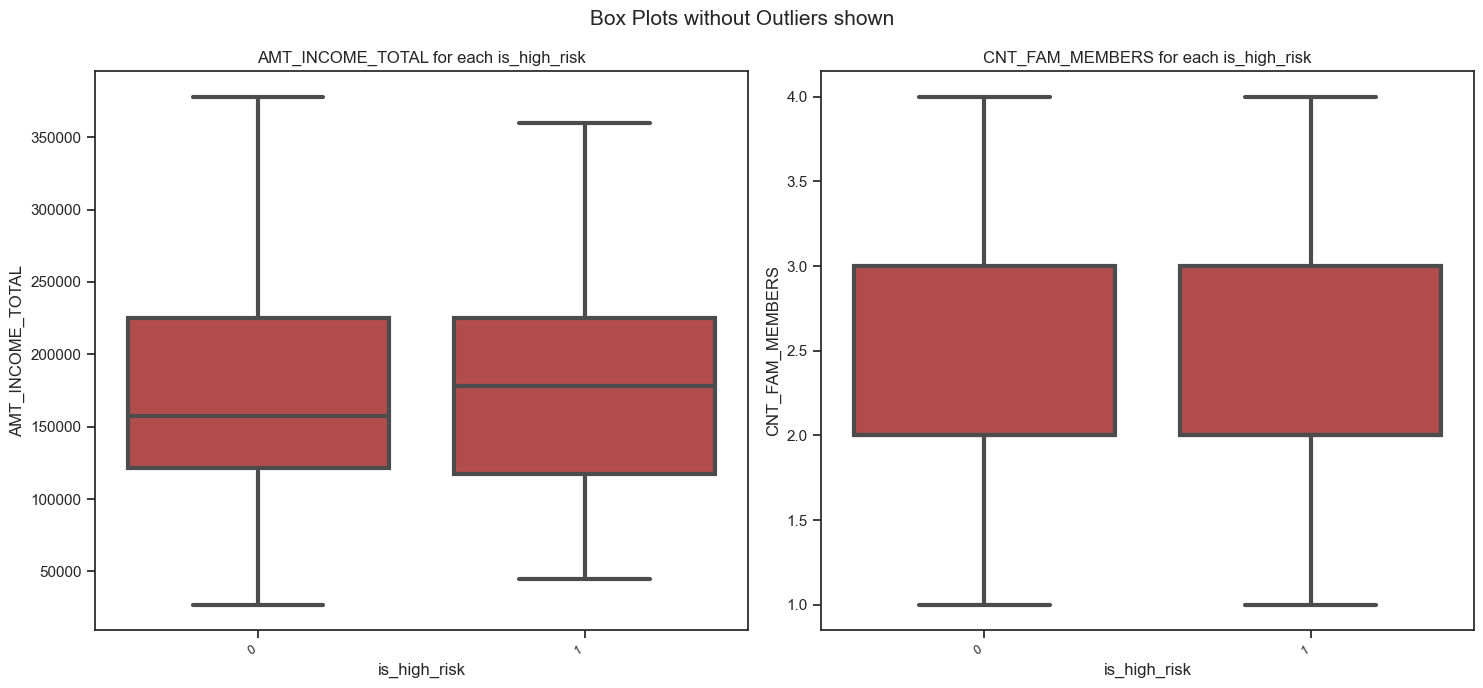

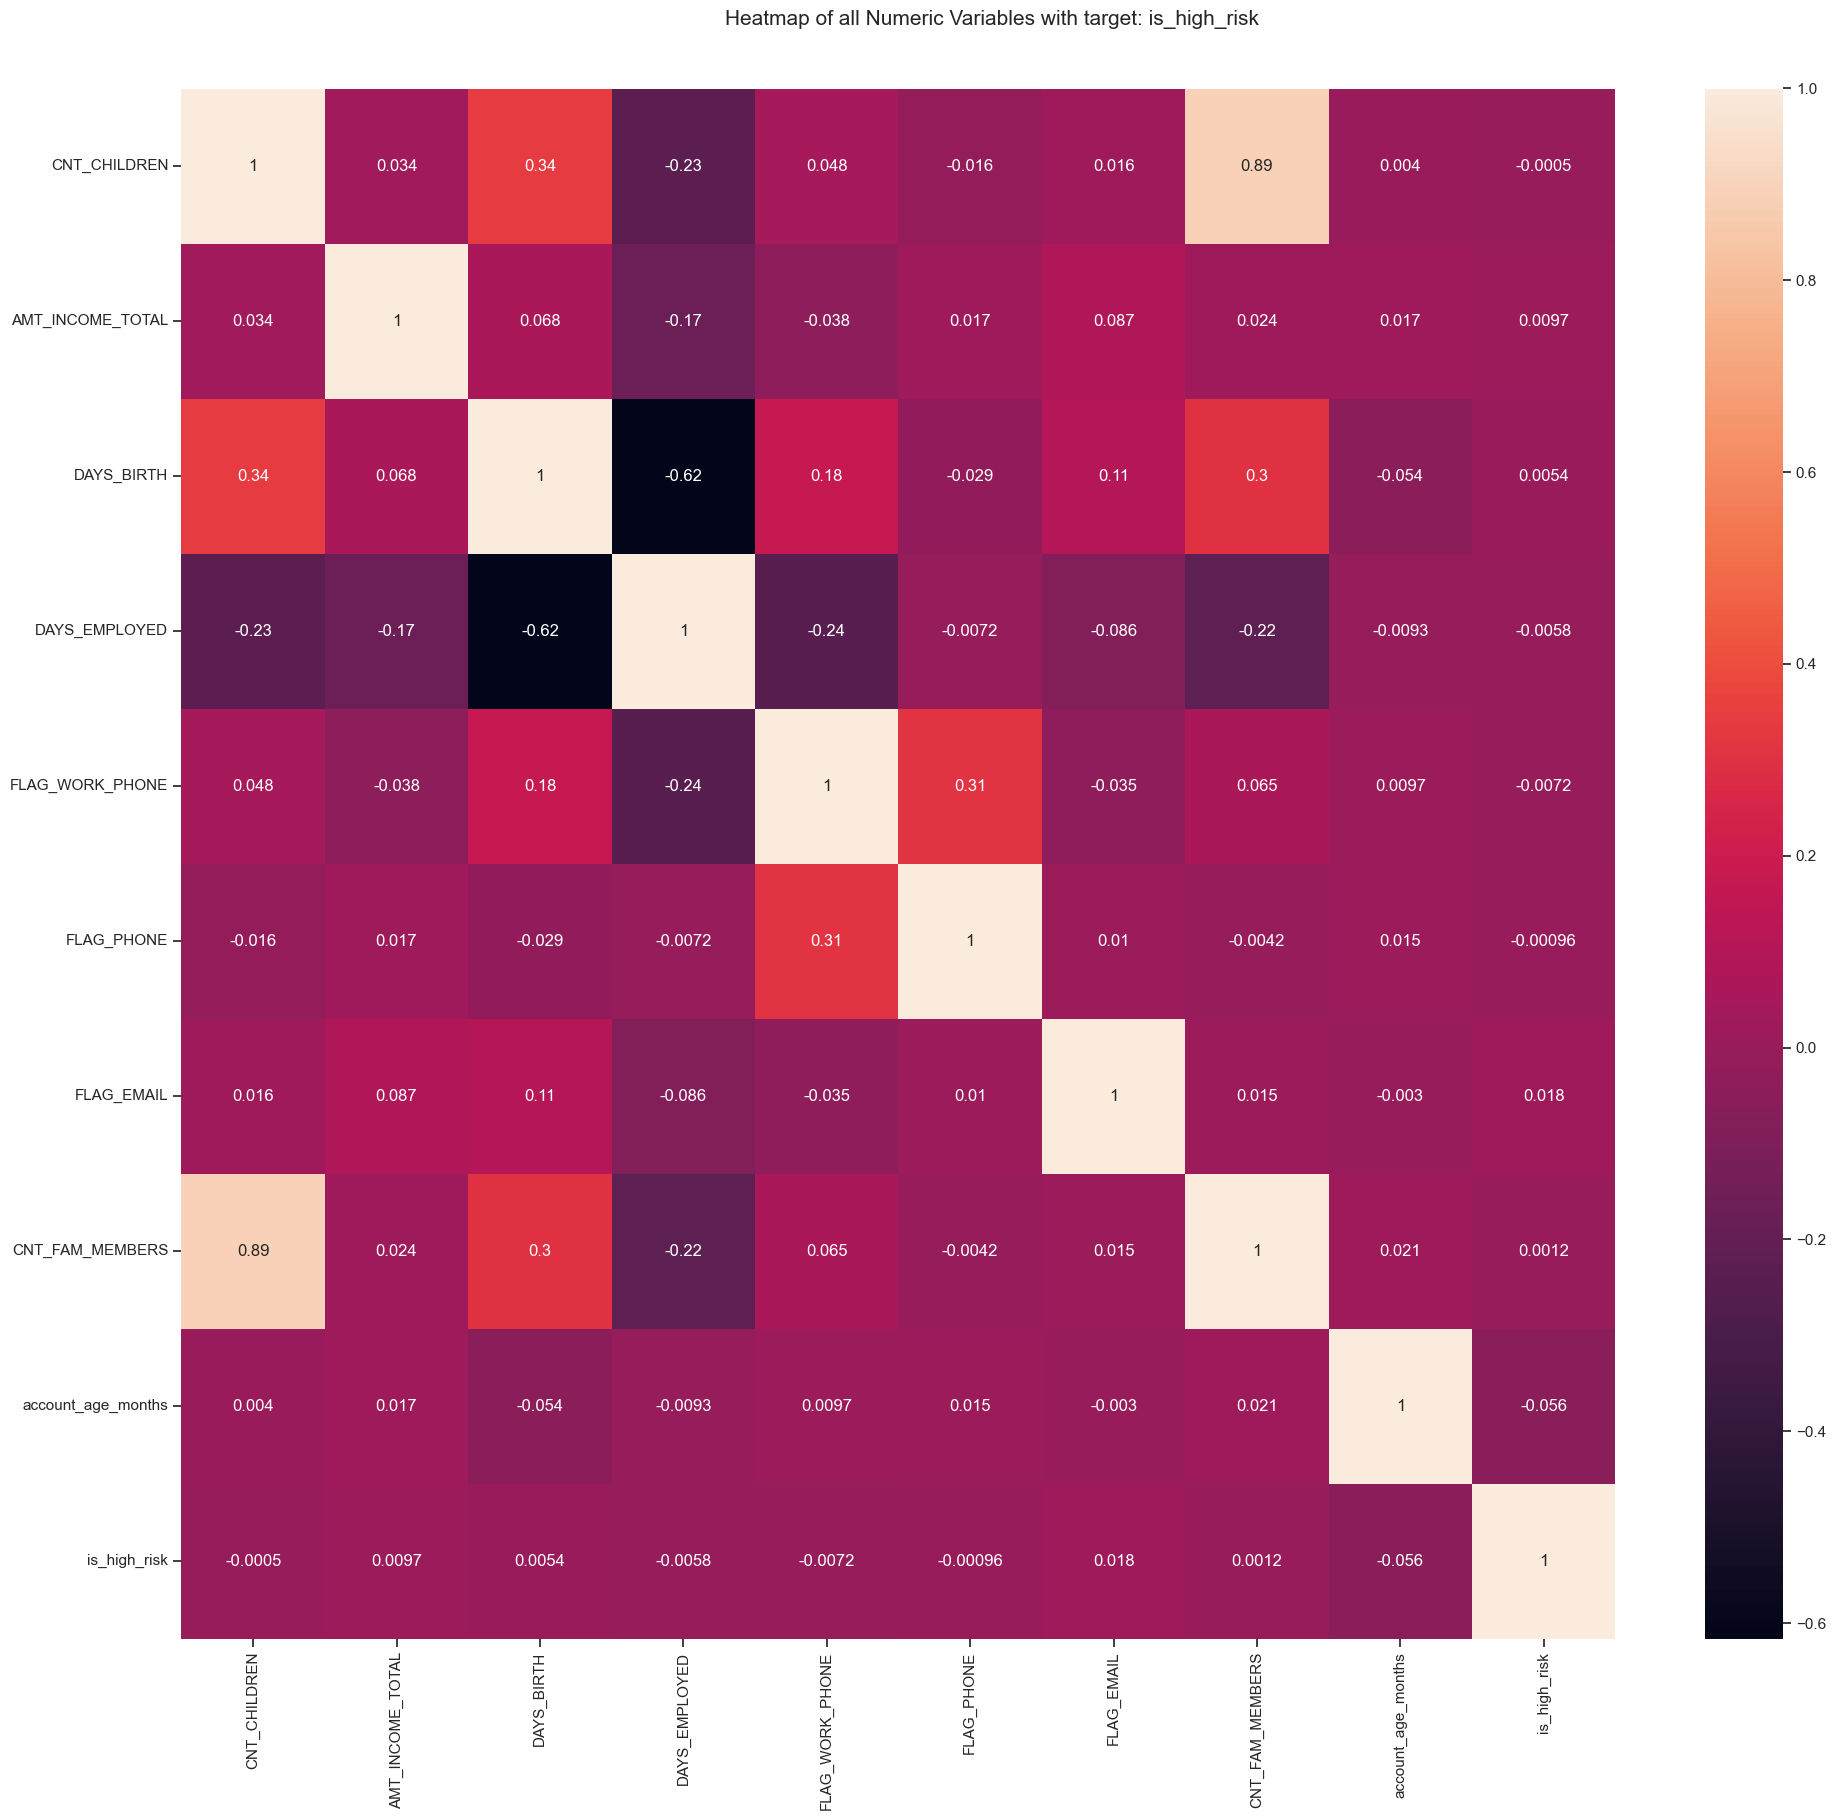

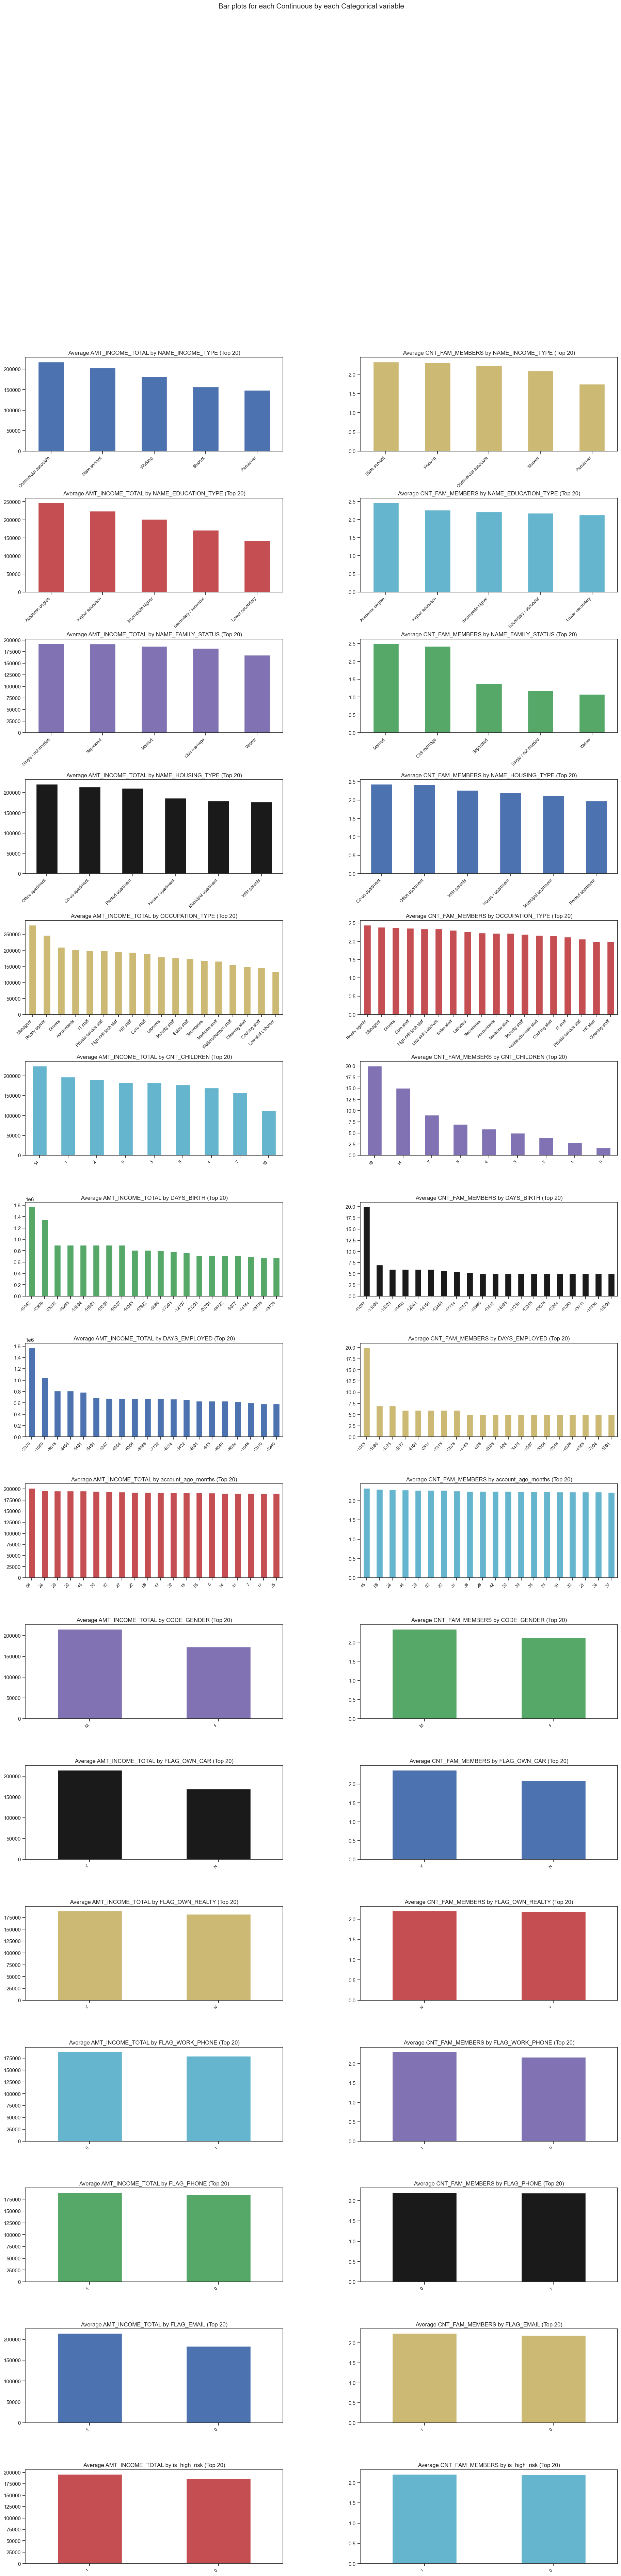

In [6]:
# Autoviz display
%matplotlib inline
AV = AutoViz_Class()
dfte = AV.AutoViz(filename="", sep=',', depVar='is_high_risk', dfte=merged_df, header=0, verbose=2, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir="reports_html")

In [7]:
#autoviz report to html
#generate_autoviz_html_report(folder_name="reports_html/is_high_risk", output_filename="credit_card_eda_report.html")

### Initial EDA Summary 

*Project Goal (Recap)*

> Build a predictive model to identify **high-risk** customers for credit card approval

- **Initial EDA Summary**

| **Summary**                                      | **Implication**                                                                 | **Proposed Preprocessing**                                                                 |
|--------------------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| Target variable is imbalanced                   | Model may be biased towards the majority class                                  | Apply resampling techniques (SMOTE/undersampling), or use class weights in model training |
| Some numeric features are skewed (e.g., income) | Skewed distributions can affect model performance and assumptions               | Apply log or Box-Cox transformation to normalize distributions                            |
| Outliers present in numeric features            | Outliers can distort model training and metrics                                 | Detect and treat outliers using IQR, Z-score, or clipping                                 |
| Categorical variables show predictive patterns  | Important for model learning and interpretability                               | Encode using one-hot or target encoding depending on cardinality                          |
| Weak multicollinearity overall                  | Features are largely independent                                                | Minimal action needed, retain current features                                             |
| Some numeric features moderately correlate with target | Useful predictors identified                                                 | Prioritize these features in model; consider feature selection techniques                 |
| Visual clusters in pairwise scatter plots       | Potential for separability between classes                                      | Normalize or scale data for algorithms sensitive to feature magnitude (e.g., SVM, KNN)    |





## DQ Issues Summary Report & Data Preprocessing

- *Data Quality Table*

| **DQ Issues**                            | **Implication**                                                                 | **Suggested Action**                                                                 |
|---------------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| `CNT_CHILDREN` has outliers and high correlation with `CNT_FAM_MEMBERS` | May distort analysis; redundancy present                             | Cap; drop one of the correlated columns `CNT_FAM_MEMBERS`                             |
| `AMT_INCOME_TOTAL` contains extreme outliers | Can skew models and mean-based stats                                             | Cap                                                             |
| Rare categories in `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `STATUS` | Unstable model behavior due to sparse classes                        | Group categories                                                       |
| `DAYS_EMPLOYED` has significant outliers     | Unrealistic values may affect time-based models                                 | Cap                               |
| `OCCUPATION_TYPE` has missing values, rare categories, and mixed types | Incomplete and inconsistent data                                                 |drop                       |
| `CNT_FAM_MEMBERS` contains outliers          | Outliers can distort predictions                                                 | Cap                                        |
| Target class imbalance (`Is_high_risk`)      | Model may favor majority class                                                  | Apply SMOTE or class weighting                                                      |
| Skewed numeric distributions                 | Skewed features can reduce model performance                                    | Apply log or Box-Cox transformations                                                |
| Need to prepare data for modeling            | Model accuracy depends on clean input                                           | Scale features (StandardScaler or MinMaxScaler)                                     |
| Feature utility may be improved              | May increase model expressiveness                                               | Create bins (e.g., for credit metrics); generate interaction features               |
| Choice of model affects predictive power     | Some models handle imbalance and non-linearity better                           | Use tree-based models (Random Forest, XGBoost); test logistic regression as baseline |
| Performance metric choice matters            | Affects how success is measured                                                 | Optimize using AUC, recall, and precision                                           |

*In summary,*
> - Handle Rare categories, Outliers(capping), missing values in `OCCUPATION_TYPE`== drop
> - Scale features (StandardScaler/MinMaxScaler)
> - Transform skewed variables (log/Box-Cox)
> - Address class imbalance

In [7]:
cleaned_df = merged_df.copy()

In [8]:
# Standardize text columns
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.strip().str.lower()  # convert to lowercase for consistency

In [9]:
# check datatypes
detect_columns(cleaned_df)

,Category,Columns,Count
0,Dates,[],0
1,Numerical,"[ID, CNT_CHILDREN, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, account_age_months, is_high_risk]",12
2,Binary,"[CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY]",3
3,Multi-Category,"[NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE]",4
4,Irrelevant,[OCCUPATION_TYPE],1


In [10]:
# Drop redundant/ID Column
cleaned_df.drop(['OCCUPATION_TYPE','CNT_FAM_MEMBERS', 'ID'], axis="columns", inplace=True)

#### Address column inconsistencies

In [11]:
# clean up columns 
# Convert days to years for better interpretability
cleaned_df['AGE_YEARS'] = ((cleaned_df['DAYS_BIRTH']).astype("Int64") / -365).astype("Int64")
cleaned_df['EMPLOYMENT_YEARS'] = cleaned_df['DAYS_EMPLOYED'].apply(
    lambda x: 0 if x > 0 else int(abs(x) / 365)
)

# Create income brackets
cleaned_df['INCOME_BRACKET'] = pd.cut(cleaned_df['AMT_INCOME_TOTAL'], 
                                    bins=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, float('inf')],
                                    labels=['<50k', '50k-100k', '100k-150k', '150k-200k', 
                                           '200k-250k', '250k-300k', '300k-350k', '>350k'])

# Children categories
cleaned_df['CHILDREN_CATEGORY'] = pd.cut(
    cleaned_df['CNT_CHILDREN'],
    bins=[-1, 0, 1, 2, 3, 5, float('inf')],
    labels=['no_children', 'one_child', 'two_children', 'three_children', 'few_children', 'many_children']
)
# Children: none(0), one(1), two(2), three(3), few(4-5), many(6+)

# Drop original columns that have been transformed # Drop constant columns (FLAG_MOBIL is always 1)
columns_to_drop = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL']
cleaned_df = cleaned_df.drop(columns=columns_to_drop)

# Clean and map education type
education_map = {
    'lower secondary': 'lower secondary',
    'incomplete higher': 'incomplete higher',
    'secondary / secondary special': 'secondary',
    'higher education': 'higher',
    'academic degree': 'degree'
}
cleaned_df['NAME_EDUCATION_TYPE'] = cleaned_df['NAME_EDUCATION_TYPE'].map(education_map)

# Group rare income types
income_counts = cleaned_df['NAME_INCOME_TYPE'].value_counts(normalize=True)
rare_income_types = income_counts[income_counts < 0.01].index
cleaned_df['NAME_INCOME_TYPE'] = cleaned_df['NAME_INCOME_TYPE'].replace(rare_income_types, 'other')

# Group rare housing types and map to cleaner labels
housing_map = {
    'rented apartment': 'rented',
    'house / apartment': 'owned',
    'municipal apartment': 'municipal',
    'with parents': 'with_parents',
    'co-op apartment': 'other',
    'office apartment': 'other'
}
cleaned_df['NAME_HOUSING_TYPE'] = cleaned_df['NAME_HOUSING_TYPE'].map(housing_map)
cleaned_df.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,account_age_months,is_high_risk,AGE_YEARS,EMPLOYMENT_YEARS,INCOME_BRACKET,CHILDREN_CATEGORY
0,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,15,0,32,12,>350k,no_children
1,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,14,0,32,12,>350k,no_children
2,m,y,y,0,112500.0,working,secondary,married,owned,0,0,0,29,0,58,3,100k-150k,no_children


In [12]:
# Rename and Reorder Columns
column_mapping = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children_count',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'employment_status',
    'NAME_EDUCATION_TYPE': 'education_level',
    'NAME_FAMILY_STATUS': 'married_status',
    'NAME_HOUSING_TYPE': 'dwelling',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'account_age_months' : 'account_age_months',
    'AGE_YEARS': 'age',
    'EMPLOYMENT_YEARS': 'employment_length',
    'INCOME_BRACKET': 'income_bracket',
    'CHILDREN_CATEGORY': 'family_members',
    
}
cleaned_df = cleaned_df.rename(columns=column_mapping)[list(column_mapping.values()) + ['is_high_risk']]
cleaned_df['is_high_risk'] = cleaned_df['is_high_risk'].astype("Int64")
display(cleaned_df.head(4))
display(cleaned_df.info())


,gender,own_car,own_property,children_count,income,employment_status,education_level,married_status,dwelling,work_phone,phone,email,account_age_months,age,employment_length,income_bracket,family_members,is_high_risk
0,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,15,32,12,>350k,no_children,0
1,m,y,y,0,427500.0,working,higher,civil marriage,rented,1,0,0,14,32,12,>350k,no_children,0
2,m,y,y,0,112500.0,working,secondary,married,owned,0,0,0,29,58,3,100k-150k,no_children,0
3,f,n,y,0,270000.0,commercial associate,secondary,single / not married,owned,0,1,1,4,52,8,250k-300k,no_children,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              36457 non-null  object  
 1   own_car             36457 non-null  object  
 2   own_property        36457 non-null  object  
 3   children_count      36457 non-null  int64   
 4   income              36457 non-null  float64 
 5   employment_status   36457 non-null  object  
 6   education_level     36457 non-null  object  
 7   married_status      36457 non-null  object  
 8   dwelling            36457 non-null  object  
 9   work_phone          36457 non-null  int64   
 10  phone               36457 non-null  int64   
 11  email               36457 non-null  int64   
 12  account_age_months  36457 non-null  int64   
 13  age                 36457 non-null  Int64   
 14  employment_length   36457 non-null  int64   
 15  income_bracket      36457 non-null  

None

In [13]:
cleaned_df.describe()

,children_count,income,work_phone,phone,email,account_age_months,age,employment_length,is_high_risk
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.0,36457.000000,36457.0
mean,0.430315,1.866857e+05,0.225526,0.294813,0.089722,26.164193,43.260334,5.614560,0.010478
std,0.742367,1.017892e+05,0.417934,0.455965,0.285787,16.501854,11.510414,6.417027,0.101826
min,0.000000,2.700000e+04,0.000000,0.000000,0.000000,0.000000,20.0,0.000000,0.0
25%,0.000000,1.215000e+05,0.000000,0.000000,0.000000,12.000000,34.0,1.000000,0.0
50%,0.000000,1.575000e+05,0.000000,0.000000,0.000000,24.000000,42.0,4.000000,0.0
75%,1.000000,2.250000e+05,0.000000,1.000000,0.000000,39.000000,53.0,8.000000,0.0
max,19.000000,1.575000e+06,1.000000,1.000000,1.000000,60.000000,68.0,43.000000,1.0


#### Handling outliers (cap)

In [19]:
# Check for outliers across all numeric columns using IQR
outlier_counts = detect_outliers_all(cleaned_df)
outlier_counts

,outlier_count
children_count,508
income,1529
account_age_months,0
age,0
employment_length,1999


In [20]:
#print(cleaned_df.select_dtypes(include=['int64', 'float64']).describe())

       children_count     income      work_phone       phone         email     \
count   36457.000000   3.645700e+04  36457.000000  36457.000000  36457.000000   
mean        0.430315   1.866857e+05      0.225526      0.294813      0.089722   
std         0.742367   1.017892e+05      0.417934      0.455965      0.285787   
min         0.000000   2.700000e+04      0.000000      0.000000      0.000000   
25%         0.000000   1.215000e+05      0.000000      0.000000      0.000000   
50%         0.000000   1.575000e+05      0.000000      0.000000      0.000000   
75%         1.000000   2.250000e+05      0.000000      1.000000      0.000000   
max        19.000000   1.575000e+06      1.000000      1.000000      1.000000   

       account_age_months     age     employment_length  is_high_risk  
count     36457.000000       36457.0    36457.000000        36457.0    
mean         26.164193     43.260334        5.614560       0.010478    
std          16.501854     11.510414        6.417027  

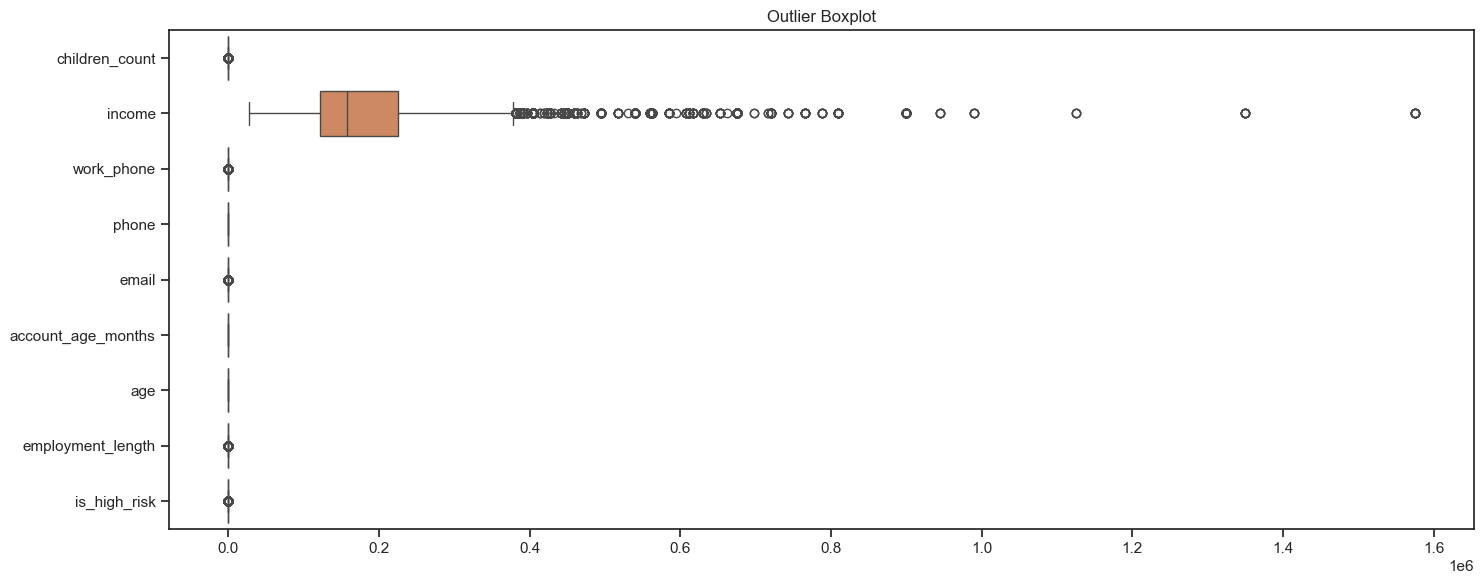

In [22]:
# plot outlier
plot_outliers_boxplot(cleaned_df, title="Outlier Boxplot", figsize=(15, 6))

In [23]:
#cap all outliers
capped_df= cleaned_df.copy()
columns_with_outliers = outlier_counts[outlier_counts['outlier_count'] > 0].index.tolist()

for col in columns_with_outliers:
    capped_df = cap_outliers(capped_df, col)
#capped_df = cap_outliers(cleaned_df, 'income')
#capped_df = cap_outliers(cleaned_df, 'children_count')
#capped_df = cap_outliers(cleaned_df, 'employment_length')


Processing children_count for outliers...
Found 508 outliers (1.39% of data)
Lower bound: -1.50, Upper bound: 2.50
Remaining outliers after capping: 0

Processing income for outliers...
Found 1529 outliers (4.19% of data)
Lower bound: -33750.00, Upper bound: 380250.00
Remaining outliers after capping: 0

Processing employment_length for outliers...
Found 1999 outliers (5.48% of data)
Lower bound: -9.50, Upper bound: 18.50
Remaining outliers after capping: 0


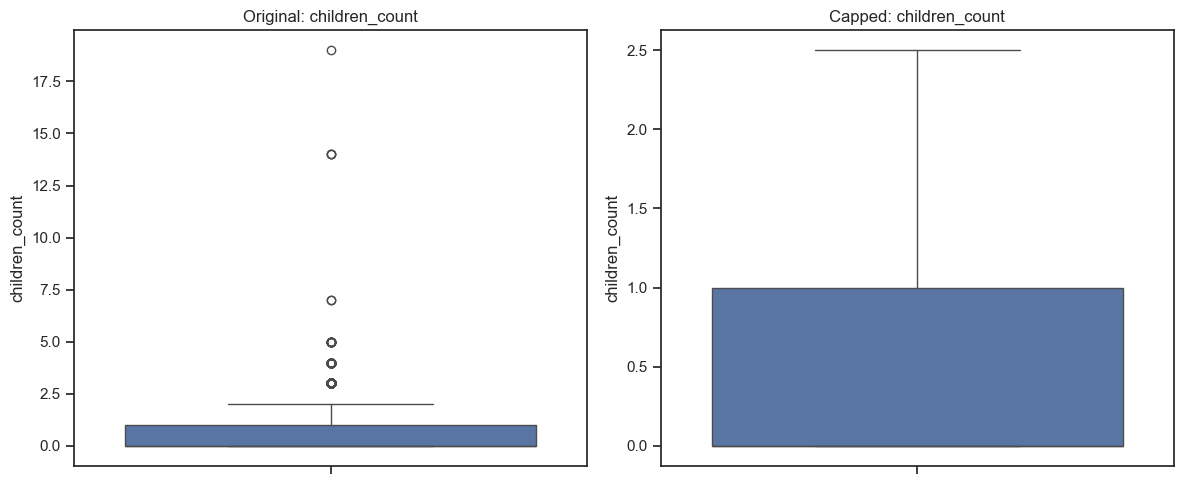

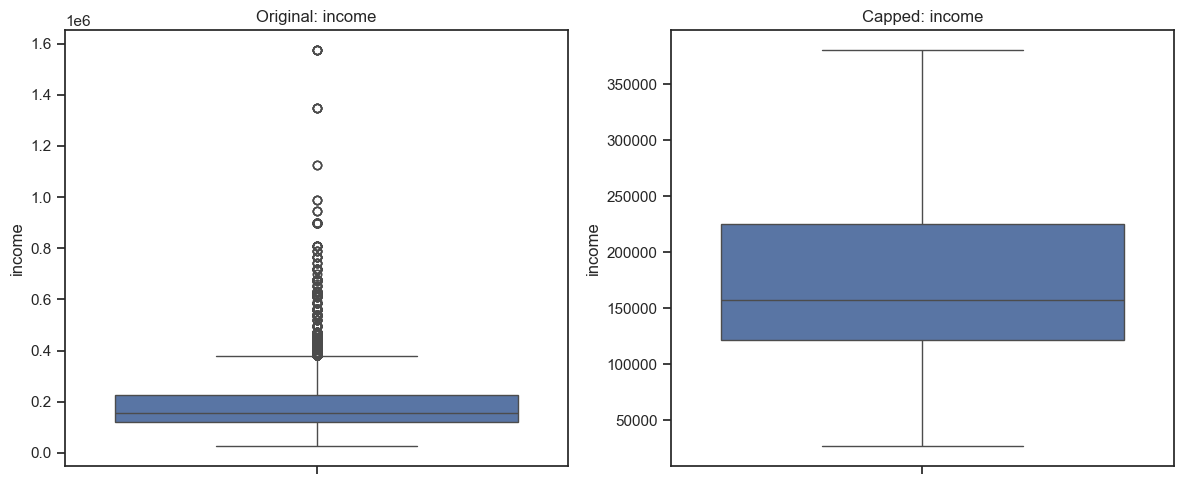

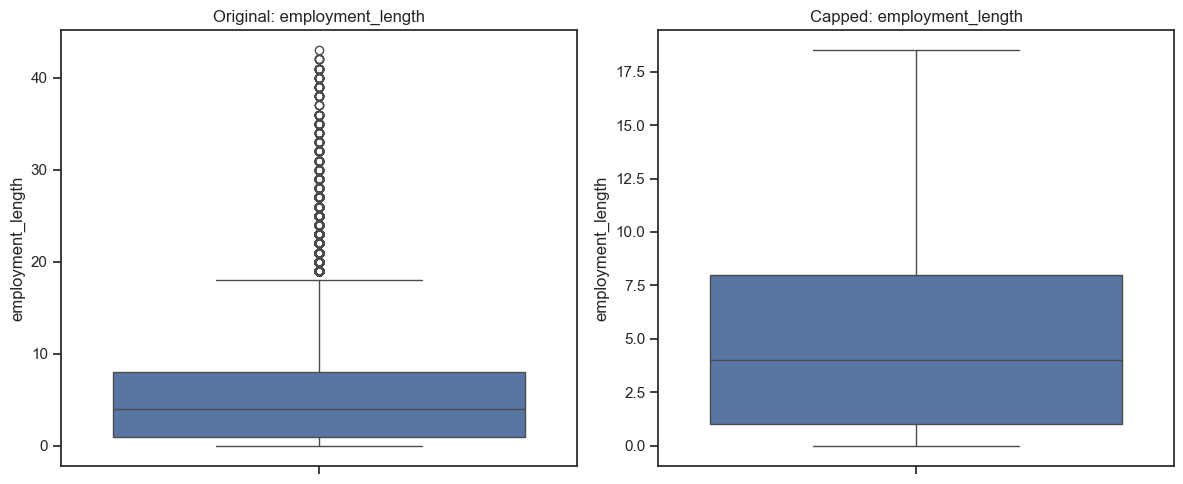

In [24]:
# Get columns with outliers (where count > 0)
columns_with_outliers = outlier_counts[outlier_counts['outlier_count'] > 0].index.tolist()

for col in columns_with_outliers:
    plot_outlier_distributions(cleaned_df, capped_df, col)

## Correlations & Hypothesis Testing (CHI-SQUARE & ANOVA)

- This section uses Chi-Square Test to test if a categorical column has a relation with is_high_risk label while also presenting visualizations to explore how each feature is distributed across risky and non-risky customers.

In [25]:
# Step 1: Run batch chi-square test
cat_cols = capped_df.select_dtypes(include='object').columns.tolist()
chi_summary = chi_square_test_batch(capped_df, cat_cols, target_column='is_high_risk', plot=False)
chi_summary.sort_values('p_value')

,feature,p_value,significant
0,gender,0.0102,True
3,employment_status,0.1148,False
4,education_level,0.2536,False
2,own_property,0.3094,False
5,married_status,0.4002,False
6,dwelling,0.5896,False
1,own_car,0.9537,False


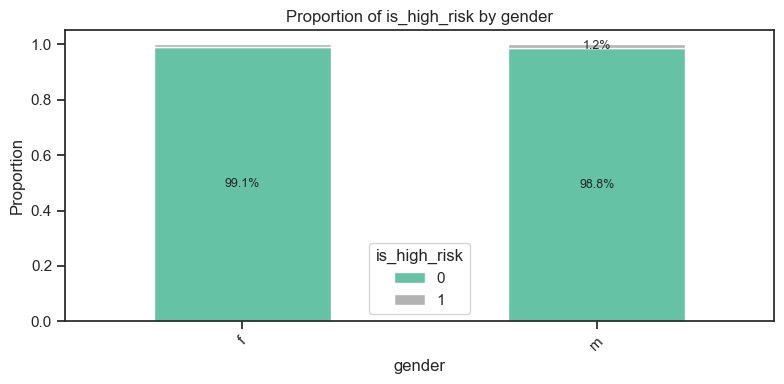

In [26]:
# Step 1b: Dynamically select significant features (excluding is_high_risk itself)
significant_features = chi_summary[
    (chi_summary['significant'] == True) &
    (chi_summary['feature'] != 'is_high_risk')
]['feature'].tolist()

# Step 3: Plot proportions
plot_significant_categorical_proportions(capped_df, significant_features, target_column='is_high_risk')


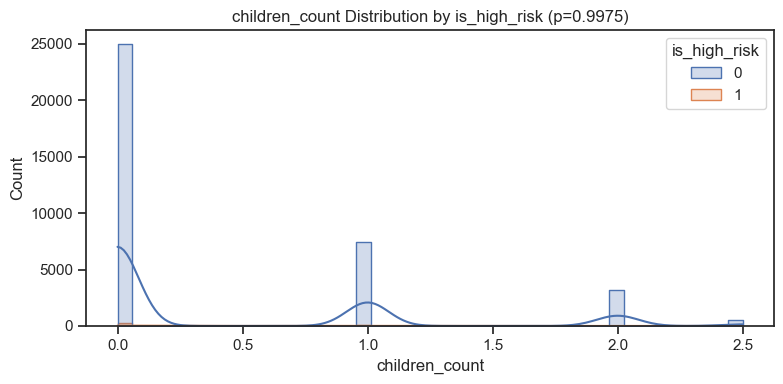

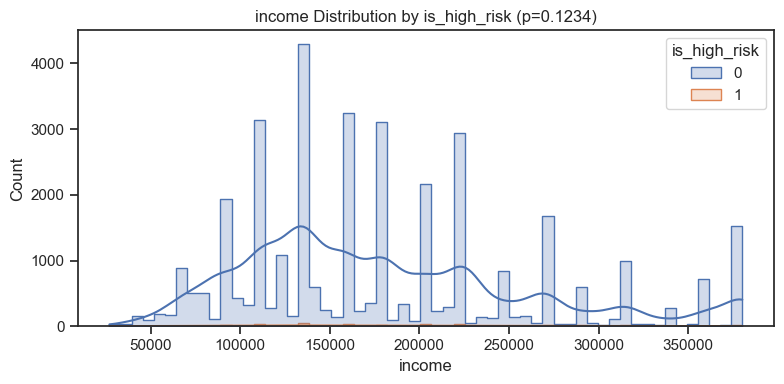

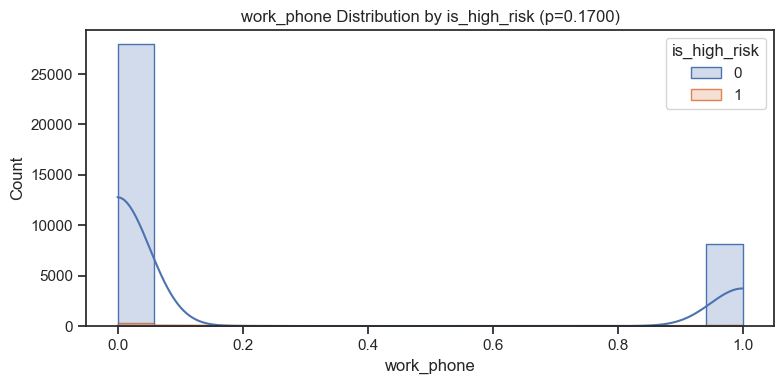

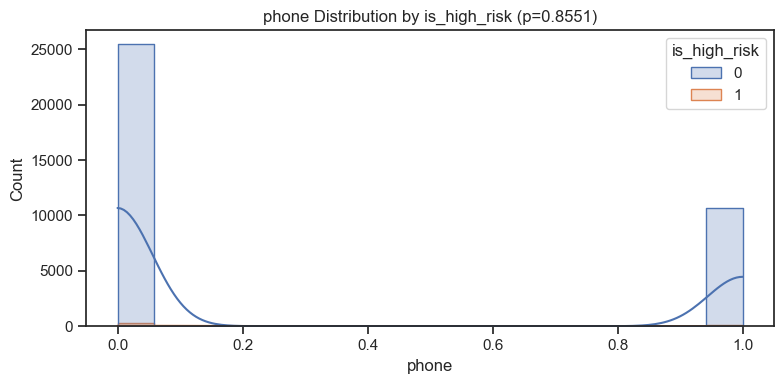

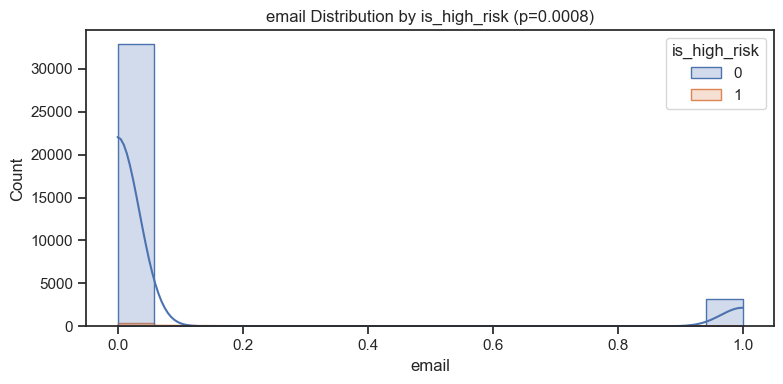

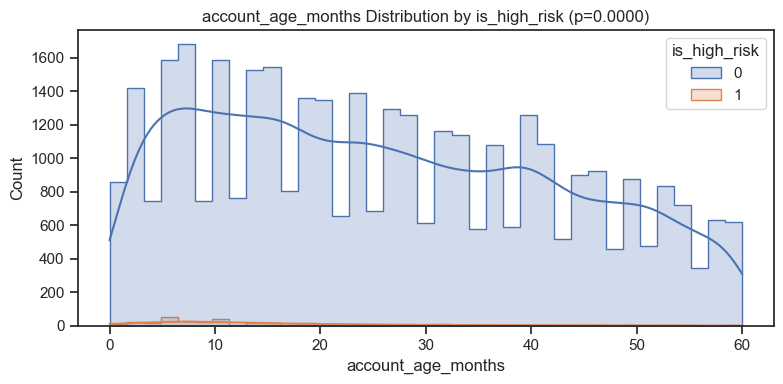

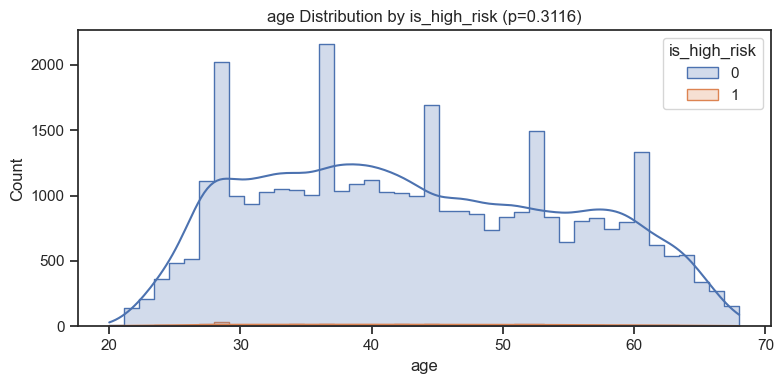

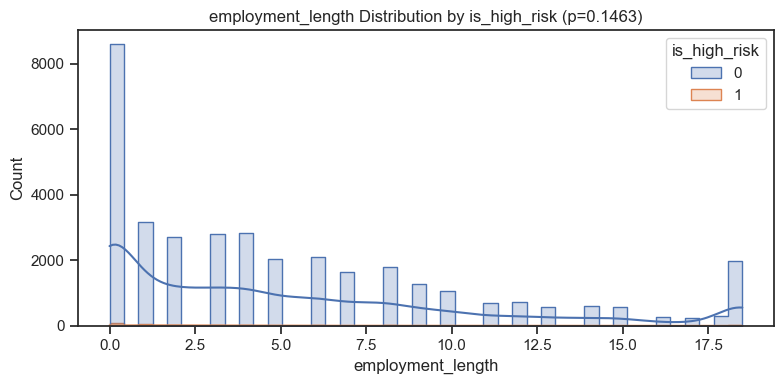

,feature,p_value,significant
5,account_age_months,0.0000,True
4,email,0.0008,True
1,income,0.1234,False
7,employment_length,0.1463,False
2,work_phone,0.1700,False
6,age,0.3116,False
3,phone,0.8551,False
0,children_count,0.9975,False


In [27]:
#Step 2: ANOVA test
anova_results = anova_test_numerical_features(capped_df, target_column='is_high_risk', plot=True)
anova_results.sort_values('p_value')

### Business Findings from EDA

**Key Statistical Insights**

| **Insight**                                      | **Implication**                                                                 |
|--------------------------------------------------|----------------------------------------------------------------------------------|
| `gender` is significantly associated with credit risk | Gender may influence risk likelihood slightly (e.g., females more/less likely flagged) |
| `account_age_months` and `email` are significant numeric predictors | Longer account age and having an email may reflect more reliable or established behavior |
| Most categorical features (`own_car`, `own_property`, `married_status`, etc.) are not statistically significant | These features likely offer limited predictive value and may be deprioritized |
| `employment_length` and `income` are not significant | Credit risk does not strongly depend on tenure or salary level |
| Most users are aged 20–45 and have account age ≤ 25 months | Reflects a young and recently onboarded customer base |

---

**Summary Narrative**

- **Typical profile of an applicant is:**
> *a Female in her early 40s, married with a partner and no child. She has been employed for 5 years with a salary of 157,500. She has completed her secondary education. She does not own a car but owns a property (a house/apartment). Her account is 26 months old.*

- **`Age` and `income` do not have any effects on the target variable.**

- **Those who are flagged as bad clients tend to have `older account`s and are more likely to have provided an email. They also constitute less than 2% of total applicants.**

- **Most applicants are 20 to 45 years old and have an account that is 25 months old or less.**

- **Categorical variables like `car ownership`, `dwelling type`, and `education level` do not significantly impact `credit risk prediction`.**

- **`Account age` will be dropped likewise because it was used to create the target variable, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.**

---

## Prepare capped data for modelling (Feature Engineering)

**Steps:**
> - Transform skewed features (log/Box-Cox)
> - Encode categorical variables (binary/one-hot/label)
> - Scale numerical features (Min-Max or Standard)
> - Address class imbalance

In [28]:
# Drop account_age
capped_df = capped_df.drop('account_age_months', axis=1)

In [29]:
# Log-transform skewed features with skew > 1
df_log_transformed = transform_skewed_features(capped_df, method='log', threshold=1.0)
df_log_transformed.head(3)

,gender,own_car,own_property,children_count,income,employment_status,education_level,married_status,dwelling,work_phone,phone,email,age,employment_length,income_bracket,family_members,is_high_risk
0,m,y,y,0.0,380250.0,working,higher,civil marriage,rented,1,0,0,32,12.0,>350k,no_children,0
1,m,y,y,0.0,380250.0,working,higher,civil marriage,rented,1,0,0,32,12.0,>350k,no_children,0
2,m,y,y,0.0,112500.0,working,secondary,married,owned,0,0,0,58,3.0,100k-150k,no_children,0
3,f,n,y,0.0,270000.0,commercial associate,secondary,single / not married,owned,0,1,1,52,8.0,250k-300k,no_children,0
4,f,n,y,0.0,270000.0,commercial associate,secondary,single / not married,owned,0,1,1,52,8.0,250k-300k,no_children,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,m,y,y,0.0,315000.0,working,secondary,married,owned,0,0,0,47,6.0,300k-350k,no_children,1
36453,f,n,y,0.0,157500.0,commercial associate,higher,married,owned,0,1,1,33,3.0,150k-200k,no_children,0
36454,f,n,y,0.0,157500.0,pensioner,higher,married,owned,0,1,1,33,3.0,150k-200k,no_children,0
36455,f,n,y,0.0,283500.0,working,secondary,married,owned,0,0,0,49,1.0,250k-300k,no_children,1


In [30]:
# Encoding categorical variables (binary encoding and one-hot encoding).
df_encoded = encode_categorical_features(
    df_log_transformed,
    binary_encode=True,
    one_hot_encode=True,
    label_encode_cols=False,
    drop_original=True
)
df_encoded.head(3)

,children_count,income,work_phone,phone,email,age,employment_length,income_bracket,family_members,is_high_risk,gender_bin,own_car_bin,own_property_bin,employment_status_other,employment_status_pensioner,employment_status_state servant,employment_status_working,education_level_higher,education_level_incomplete higher,education_level_lower secondary,education_level_secondary,married_status_married,married_status_separated,married_status_single / not married,married_status_widow,dwelling_other,dwelling_owned,dwelling_rented,dwelling_with_parents
0,0.0,380250.0,1,0,0,32,12.0,>350k,no_children,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
1,0.0,380250.0,1,0,0,32,12.0,>350k,no_children,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,112500.0,0,0,0,58,3.0,100k-150k,no_children,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0


In [31]:
# scale for numerical attributes and split df for modelling
X_train, X_test, y_train, y_test, pipeline = scale_and_split(
    df_encoded,
    target_column='is_high_risk'
)
X_train.head(3)

ValueError: Cannot cast object dtype to float64

In [ ]:
# Balance the training set
y_train.value_counts()
X_train_resampled, y_train_resampled = balance_classes_smote(X_train, y_train)
print(y_train_resampled.value_counts())

In [ ]:
# Binary encoding for gender, car ownership, and realty ownership
cleaned_df['CODE_GENDER'] = cleaned_df['CODE_GENDER'].map({'m': 0, 'f': 1})
cleaned_df['FLAG_OWN_CAR'] = cleaned_df['FLAG_OWN_CAR'].map({'n': 0, 'y': 1})
cleaned_df['FLAG_OWN_REALTY'] = cleaned_df['FLAG_OWN_REALTY'].map({'n': 0, 'y': 1})

# One-hot encoding for categorical variables
categorical_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
cleaned_df = pd.get_dummies(cleaned_df, columns=categorical_columns, prefix=categorical_columns)


## Modeling
- Use tree-based models (Random Forest, XGBoost)
- Try logistic regression as baseline
- Optimize using AUC/recall/precision

In [1]:
# streamlit

In [ ]:
import streamlit as st
import eda
import prediction

page = st.sidebar.selectbox('Pilih Halaman', ('EDA', 'Prediction'))

if page=='EDA':
    eda.run()
else:
    prediction.run()

In [ ]:
import streamlit as st
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

def run():

    #Membuat judul
    st.title('Credit Card Analysis and Prediction')

    image = Image.open('credit_card.jpeg')
    st.image(image, caption='Credit Card')

    st.markdown('------')

    #Sub judul untuk Exploratory Data Analysis
    st.subheader('Exploratory Data Analysis Credit Card')

    #Memanggil dataset
    credit_card_data = pd.read_csv('P1G5_Set_1_Christopher.csv')
    credit_card_data

    st.write("#### Penggunaan Credit Card berdasarkan Age")
    fig = plt.figure(figsize=(20, 15))
    sns.countplot(credit_card_data, x="age")
    st.pyplot(fig)

    st.write("#### Limit Balance menurut Education Level")
    limit_by_education = credit_card_data.groupby('education_level')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_education.education_level, limit_by_education.limit_balance, label=limit_by_education.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

    st.write("#### Limit Balance menurut Age")
    limit_by_age = credit_card_data.groupby('age')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_age.age, limit_by_age.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

if __name__ == "__main__":
    run()

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import pickle
from sklearn import *

with open('best_models_knc.pkl', 'rb') as file_3:
  knc_model = pickle.load(file_3)

with open('best_models_svc.pkl', 'rb') as file_6:
  svc_model = pickle.load(file_6)

with open('best_models_logreg.pkl', 'rb') as file_7:
  logreg_model = pickle.load(file_7)

def run():
    st.title('Prediction Credit Card Default or Not')

    with st.form('form_credit_card'):
       limit_balance = st.slider('Limit Balance', min_value = 0, max_value = 500000, value = 150000, help='Slide limit balance anda')
       pay_amt_1 = st.slider('Input Payment 1', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment pertama anda')
       pay_amt_2 = st.slider('Input Payment 2', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kedua anda')
       pay_amt_3 = st.slider('Input Payment 3', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment ketiga anda')
       pay_amt_4 = st.slider('Input Payment 4', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keempat anda')
       pay_amt_5 = st.slider('Input Payment 5', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kelima anda')
       pay_amt_6 = st.slider('Input Payment 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keenam anda')
       education_level = st.slider('Education Level', min_value = 0, max_value = 6, value = 3, help='Slide education level anda')
       pay_0 = st.slider('Input Payment 1', min_value = -2, max_value = 9, value = 3, help='Slide status payment pertama anda')
       pay_2 = st.slider('Input Payment 2', min_value = -2, max_value = 9, value = 3, help='Slide status payment kedua anda')
       pay_3 = st.slider('Input Payment 3', min_value = -2, max_value = 9, value = 3, help='Slide status payment ketiga anda')
       pay_4 = st.slider('Input Payment 4', min_value = -2, max_value = 9, value = 3, help='Slide status payment keempat anda')
       pay_5 = st.slider('Input Payment 5', min_value = -2, max_value = 9, value = 3, help='Slide status payment kelima anda')
       pay_6 = st.slider('Input Payment 6', min_value = -2, max_value = 9, value = 3, help='Slide status payment keenam anda')
       bill_amt_1 = st.slider('Input Jumlah Tagihan 1', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan pertama anda')
       bill_amt_2 = st.slider('Input Jumlah Tagihan 2', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kedua anda')
       bill_amt_3 = st.slider('Input Jumlah Tagihan 3', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan ketiga anda')
       bill_amt_4 = st.slider('Input Jumlah Tagihan 4', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan keempat anda')
       bill_amt_5 = st.slider('Input Jumlah Tagihan 5', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kelima anda')
       bill_amt_6 = st.slider('Input Jumlah Tagihan 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah tagihan keenam anda')

       #submit button
       submitted = st.form_submit_button('Predict')

    data_inf = {
    "limit_balance"  :               limit_balance,
    "pay_amt_1"      :                pay_amt_1,
    "pay_amt_2"      :                pay_amt_2,
    "pay_amt_3"      :                pay_amt_3,
    "pay_amt_4"      :                pay_amt_4,
    "pay_amt_5"      :                pay_amt_5,
    "pay_amt_6"      :                pay_amt_6,
    "education_level":          education_level,
    "pay_0"          :                   pay_0,
    "pay_2"          :                   pay_2,
    "pay_3"          :                   pay_3,
    "pay_4"          :                   pay_4,
    "pay_5"          :                   pay_5,
    "pay_6"          :                   pay_6,
    "bill_amt_1"     :               bill_amt_1,
    "bill_amt_2"     :               bill_amt_2,
    "bill_amt_3"     :               bill_amt_3,
    "bill_amt_4"     :               bill_amt_4,
    "bill_amt_5"     :               bill_amt_5,
    "bill_amt_6"     :               bill_amt_6
    }       

    data_inf = pd.DataFrame([data_inf])
    data_inf

    if submitted:

        y_pred_inf = logreg_model.predict(data_inf)
        y_pred_inf

        st.write('### Default Payment Next Month: ', str(int(y_pred_inf)))


if __name__ == "__main__":
    run()